## **Import Libraries**

#### **Paper:** https://arxiv.org/pdf/2401.15884

In [1]:
import time, re
from typing import List, TypedDict
from pydantic import BaseModel

from langchain_tavily import TavilySearch
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import display, Markdown, Image

from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv

load_dotenv()

/home/muhammadumerkhan/Gen-Agentic-AI-Tutorials/.venv/lib/python3.12/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
/home/muhammadumerkhan/Gen-Agentic-AI-Tutorials/.venv/lib/python3.12/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


True

### **Load Books**

In [2]:
docs = (
    PyPDFLoader("../../../assets/books/deep_learning.pdf").load() +
    PyPDFLoader("../../../assets/books/hands_on_ml.pdf").load() +
    PyPDFLoader("../../../assets/books/pattern_recognition.pdf").load()
)

- docs length

In [3]:
len(docs)

2123

### **Split Documents into Chunks**

In [4]:
chunks = RecursiveCharacterTextSplitter(chunk_size=900, chunk_overlap=150).split_documents(docs)
for d in chunks:
    d.page_content = d.page_content.encode("utf-8", "ignore").decode("utf-8", "ignore")

### **Embedding and Indexing**

In [5]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = FAISS.from_documents(chunks, embeddings)

- **Retriever**

In [6]:
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 4})

In [7]:
retrieved_docs = retriever.invoke("Explain the bias–variance tradeoff")

In [8]:
len(retrieved_docs)

4

- **LLM**

In [9]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [11]:
class State(TypedDict):
    question: str
    docs: List[Document]

    good_docs: List[Document]
    verdict: str
    reason: str
    
    strips: List[str]
    kept_strips: List[str]
    refined_context: str

    web_docs: List[Document]

    answer: str

In [12]:
def retrieve(state: State) -> State:
    q = state["question"]
    return {"docs": retriever.invoke(q)}

- **Evaluator**

In [13]:
class DocEvalScore(BaseModel):
    score: float
    reason: str

In [69]:
doc_eval_prompt = ChatPromptTemplate.from_messages([
    (
    "system",
        "You are a strict retrieval evaluator for RAG.\n"
        "You will be given ONE retrieved chunk and a question.\n"
        "Return a relevance score in [0.0, 1.0].\n"
        "- 1.0: chunk alone is sufficient to answer fully/mostly\n"
        "- 0.0: chunk is irrelevant\n"
        "Be conservative with high scores.\n"
        "Also return a short reason.\n"
        "Output JSON only."
    ),
    (
    "human", "Question: {question}\n\nChunk:\n{chunk}"
    )
])

In [70]:
doc_eval_chain = doc_eval_prompt | llm.with_structured_output(DocEvalScore)

In [96]:
LOWER_TH = 0.3
UPPER_TH = 0.7

In [97]:
def eval_doc(state: State) -> State:

    q = state["question"]
    
    scores: List[float] = []
    reasons: List[str] = []
    good: List[Document] = []

    for d in state["docs"]:
        out = doc_eval_chain.invoke({"question": q, "chunk": d.page_content})
        scores.append(out.score)
        reasons.append(out.reason)

        # 5) for CORRECT case we will refine only docs with score > LOWER_TH
        if out.score > LOWER_TH:
            good.append(d)

    # 2) CORRECT if at least one doc > UPPER_TH
    if any(s > UPPER_TH for s in scores):
        return {
            "good_docs": good,
            "verdict": "CORRECT",
            "reason": f"At least one retrieved chunk scored > {UPPER_TH}.",
        }

    # 3) INCORRECT if all docs < LOWER_TH
    if len(scores) > 0 and all(s < LOWER_TH for s in scores):
        why = "No chunk was sufficient."
        return {
            "good_docs": [],
            "verdict": "INCORRECT",
            "reason": f"All retrieved chunks scored < {LOWER_TH}. {why}",
        }

    # 4) Anything in between => AMBIGUOUS
    why = "Mixed relevance signals."
    return {
        "good_docs": good,
        "verdict": "AMBIGUOUS",
        "reason": f"No chunk scored > {UPPER_TH}, but not all were < {LOWER_TH}. {why}",
    }

In [98]:
evaluations = eval_doc({
    "question": "Explain the bias–variance tradeoff",
    "docs": retrieved_docs
})

In [99]:
len(evaluations['good_docs'])

4

In [100]:
evaluations['verdict']

'CORRECT'

- **Sentence-level DECOMPOSER**

In [101]:
def decompose_to_sentences(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if len(s.strip()) > 20]

In [102]:
context = "\n\n".join(d.page_content for d in retrieved_docs).strip()
# context

In [103]:
decomposed_context = decompose_to_sentences(context)
len(decomposed_context)

26

**FILTER (LLM judge)**

In [104]:
class KeepDrop(BaseModel):
    keep: bool

filter_prompt = ChatPromptTemplate.from_messages([
    (
    "system",
        "You are a strict relevance filter.\n"
        "Return keep=true only if the sentence directly helps answer the question.\n"
        "Use ONLY the sentence. Output JSON only.",
    ),
    (
    "human", "Question: {question}\n\nSentence:\n{sentence}"
    )
])

In [105]:
filter_chain = filter_prompt | llm.with_structured_output(KeepDrop)

- **REFINING (Decompose -> Filter -> Recompose)**

In [187]:
def refine(state: State) -> State:
    q = state["question"]

    if state.get("verdict") == "CORRECT":
        context = "\n\n".join(d.page_content for d in state["good_docs"]).strip()
    else:
        context = "\n\n".join(d.page_content for d in state["web_docs"]).strip()

    strips = decompose_to_sentences(context)

    kept: List[str] = []
    for s in strips:
        if filter_chain.invoke({"question": q, "sentence": s}).keep:
            kept.append(s)

    refined_context = "\n".join(kept).strip()

    return {
        "strips": strips,
        "kept_strips": kept,
        "refined_context": refined_context,
    }

In [188]:
refined = refine({"question": "Explain the bias–variance tradeoff", "good_docs": retrieved_docs, "verdict": "CORRECT"})

In [189]:
# refined['refined_context']

- **WEB SEARCH**

In [204]:
def websearch(state: State) -> State:

    search_engine = TavilySearch(max_results=5)
    q = state["question"]
    results = search_engine.invoke({"query": q})

    web_docs = []
    for r in results["results"] or []:

        title = r.get("title", "")
        url = r.get("url", "")
        content = r.get("content") or r.get("snippet") or ""

        text = f"TITLE: {title}\nURL: {url}\nCONTENT: {content}"

        web_docs.append(Document(page_content=text, metadata={"title": title, "url": url}))
    
    return {"web_docs": web_docs}

In [205]:
web_searched = websearch({"question": "Explain the bias–variance tradeoff"})

In [218]:
# web_searched['web_docs'][0].page_content

- **ANSWER GENERATION**

In [219]:
answer_prompt = ChatPromptTemplate.from_messages([
    (
    "system",
        "Answer using the provided context when possible. "
        "If the context does not contain relevant information, you may say that information is limited or missing, "
        "but try to provide whatever useful pieces are present.\n"
    ),
    (
    "human", "Question: {question}\n\nRefined context:\n{refined_context}"
    ),
])

In [220]:
def generate_answer(state: State) -> State:
    output = (answer_prompt | llm).invoke({
        "question": state["question"], 
        "refined_context": state["refined_context"]
    })

    return {"answer": output.content}

- **FAIL/AMBIGUOUS NODES**

In [221]:
def ambiguous_node(state: State) -> State:
    return { "answer": f"AMBIGUOUS: {state['reason']}" }

def route_node(state: State) -> str:
    if state["verdict"] == "CORRECT":
        return "refiner"
    elif state["verdict"] == "INCORRECT":
        return "web_search"
    else:
        return "ambiguous"

- **GRAPH**

In [222]:
graph = StateGraph(State)

graph.add_node("retrieve", retrieve)
graph.add_node("eval_doc", eval_doc)
graph.add_node("websearch", websearch)
graph.add_node("refine", refine)
graph.add_node("generate_answer", generate_answer)
graph.add_node("ambiguous_node", ambiguous_node)

graph.add_edge(START, "retrieve")
graph.add_edge("retrieve", "eval_doc")

graph.add_conditional_edges(
    "eval_doc", route_node,
    { 
        "refiner":"refine",
        "web_search": "websearch", 
        "ambiguous": "ambiguous_node" 
    }
)

graph.add_edge("websearch", "refine")
graph.add_edge("refine", "generate_answer")

graph.add_edge("generate_answer", END)
graph.add_edge("ambiguous_node", END)

rag = graph.compile()

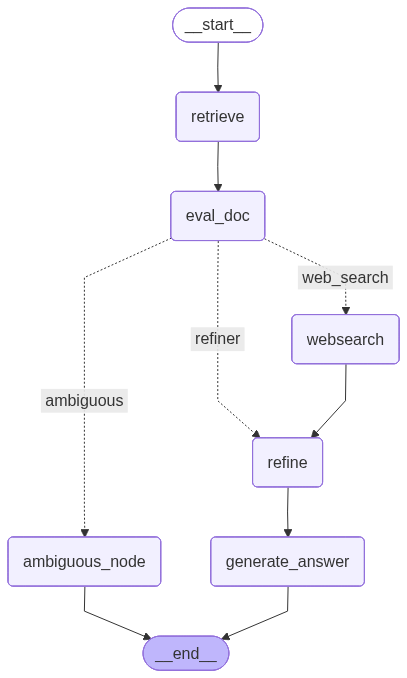

In [223]:
display(Image(rag.get_graph(xray=1).draw_mermaid_png()))

In [224]:
def run(question: str) -> dict:
    res = rag.invoke(
        {
            "question": question,
            "docs": [],
            "good_docs": [],
            "verdict": "",
            "reason": "",
            "strips": [],
            "kept_strips": [],
            "refined_context": "",
            "web_docs": [],
            "answer": "",
        }
    )
    return res

In [146]:
res = run("What are attention mechanisms and why are they important in current models?")

In [147]:
res.keys()

dict_keys(['question', 'docs', 'good_docs', 'verdict', 'reason', 'strips', 'kept_strips', 'refined_context', 'web_docs', 'answer'])

In [148]:
print("VERDICT:", res["verdict"])
print("REASON:", res["reason"])
print("\nOUTPUT:\n", res["answer"])

VERDICT: CORRECT
REASON: At least one retrieved chunk scored > 0.7.

OUTPUT:
 I don't know based on the provided books.


In [149]:
res['refined_context']

''

In [150]:
display(Markdown(res["answer"]))

I don't know based on the provided books.

- Bias variance tradeoff
- AI news from last week
- What are attention mechanisms and why are they important in current models?

In [151]:
res = run("Explain the bias–variance tradeoff")

In [152]:
print("VERDICT:", res["verdict"])
print("REASON:", res["reason"])
# print("\nOUTPUT:\n", res["answer"])

VERDICT: CORRECT
REASON: At least one retrieved chunk scored > 0.7.


In [153]:
display(Markdown(res["answer"]))

The bias–variance tradeoff is a fundamental concept in statistics and machine learning that describes the relationship between bias, variance, and the generalization error of a model. 

- Bias measures the expected deviation from the true value, often due to incorrect assumptions about the data (e.g., assuming linearity when the relationship is quadratic). High-bias models tend to underfit the training data.
- Variance measures the model's sensitivity to small variations in the training data. High-variance models can overfit the training data.
- The generalization error can be expressed as the sum of bias, variance, and a constant noise term.
- There is a trade-off: flexible models have low bias and high variance, while rigid models have high bias and low variance.
- The optimal model achieves the best balance between bias and variance.
- Increasing model complexity typically increases variance and reduces bias, while reducing complexity increases bias and decreases variance.

In [228]:
res = run("AI news from the last month")

In [229]:
print("VERDICT:", res["verdict"])
print("REASON:", res["reason"])
# print("\nOUTPUT:\n", res["answer"])

VERDICT: INCORRECT
REASON: All retrieved chunks scored < 0.3. No chunk was sufficient.


In [230]:
res['refined_context']

"TITLE: AI News: The AI Launch That Crashed The Market - YouTube URL: https://www.youtube.com/watch?v=xdp8bulnidY CONTENT: ...\nAI news stories, product launches, and model updates from the past week.\nOpenAI dropped a new Codex app and GPT-5.3-Codex, Anthropic shipped TITLE: Artificial Intelligence - Latest AI News and Analysis - WSJ.com URL: https://www.wsj.com/tech/ai?gaa_at=eafs&gaa_n=AWEtsqcSmgbZ0v5XdZg_T86LBsKW0mjVo51uygkJNP6kb5J_K3TyUL1S-MqS&gaa_ts=698ce329&gaa_sig=VH7I72FiTmw0jwKcAh4CNj3eRlV2dk0lslpL19vz2qsv8qsYsI59XCxlccrcE8-XjsIzasFKrXvCydGnaW9YzA%3D%3D CONTENT: The latest artificial intelligence news coverage focusing on the technology, tools and the companies building AI technology.\nTITLE: AI News | Latest Headlines and Developments | Reuters URL: https://www.reuters.com/technology/artificial-intelligence/ CONTENT: Explore the latest artificial intelligence news with Reuters - from AI breakthroughs and technology trends to regulation, ethics, business and global TITLE: AI 

In [231]:
display(Markdown(res["answer"]))

In the last month, several notable developments in AI have occurred:

1. **OpenAI Launches New Products**: OpenAI released a new Codex app along with the GPT-5.3-Codex, which has generated significant interest in the AI community.

2. **AI in Banking**: Malaysia has launched Ryt Bank, its first AI-powered bank, marking a significant step in the integration of AI in financial services. Additionally, Thailand has become one of the first countries in Asia to adopt the Sora app.

3. **Google's AI Tools**: Google introduced Veo 3, a new AI video creation tool, which is expected to enhance content creation capabilities.

4. **Market Reactions**: There was a notable market reaction to an AI launch that reportedly caused a market crash, highlighting the volatility and impact of AI developments on financial markets.

For more detailed coverage, you can check out sources like the Wall Street Journal, Reuters, and various AI news platforms.